# MoE


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import itertools
import os 
import sys


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from moe_model import MoE as MoE_raw, MLP as MoE_Expert

# --- Helper class to modify the MoE Expert to output raw logits ---
# This is necessary because the CrossEntropyLoss function expects logits, not probabilities.
class MoE_Expert_Logits(MoE_Expert):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__(input_size, output_size, hidden_size)
        # Replace the final softmax layer with an identity layer
        self.soft = nn.Identity()


In [17]:
def train_and_evaluate_trial(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoE model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    model = MoE_raw(
        input_size=X_train.shape[1],
        output_size=2,
        num_experts=params['num_experts'],
        hidden_size=params['hidden_size'],
        k=params['k']
    )
    model.experts = nn.ModuleList([
        MoE_Expert_Logits(
            input_size=X_train.shape[1],
            output_size=2,
            hidden_size=params['hidden_size']
        ) for _ in range(model.num_experts)
    ])
    model.to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred, aux_loss = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor) + aux_loss
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, val_aux_loss = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor) + val_aux_loss
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _ = model(X_val_tensor)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        # Get detailed metrics from classification report for class '1'
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'num_experts': params['num_experts'],
            'hidden_size': params['hidden_size'],
            'k': params['k'],
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


In [18]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'input_moe_rfe_fulldataset.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False) 
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_moe_added.csv' not found. Please ensure the correct data file is present.")

# --- 2. Define the Best Hyperparameters ---
best_params = {
    'num_experts': 6,
    'hidden_size': 64,
    'k': 4
}
print(f"\n🔹 Using best hyperparameters: {best_params}")

# --- 3. Prepare the Final Model ---
# Combine training and validation data for final training
X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

print("\nRetraining the best model on combined Train+Validation data...")

# Create the final model instance with the best parameters
final_model = MoE_raw(
    input_size=X_train_val.shape[1],
    output_size=2,
    num_experts=int(best_params['num_experts']),
    hidden_size=int(best_params['hidden_size']),
    k=int(best_params['k'])
)
final_model.experts = nn.ModuleList([
    MoE_Expert_Logits(
        input_size=X_train_val.shape[1],
        output_size=2,
        hidden_size=int(best_params['hidden_size'])
    ) for _ in range(final_model.num_experts)
])


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (1297, 31)

🔹 Using best hyperparameters: {'num_experts': 6, 'hidden_size': 64, 'k': 4}

Retraining the best model on combined Train+Validation data...


In [19]:
# --- 1. Train the final model ---
# We reuse the evaluation function as a training function here
final_results = train_and_evaluate_trial(
    best_params,
    X_train_val, y_train_val, X_test_scaled, y_test.values
)

# --- 2. Print the final performance metrics on the test set ---
print("\n\n" + "="*40 + "\n✅ FINAL MODEL PERFORMANCE ON TEST SET\n" + "="*40)
print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
print(f"  - Precision:   {final_results['val_precision']:.4f}")
print(f"  - Recall:      {final_results['val_recall']:.4f}")
print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")

# --- 3. Save the final trained model ---
# model_save_path = 'best_moe_rfe_model.pth'
# torch.save(final_model.state_dict(), model_save_path)
# print(f"\n✅ Best MoE model saved to '{model_save_path}'")




✅ FINAL MODEL PERFORMANCE ON TEST SET
  - Accuracy:    0.7374
  - ROC-AUC:     0.8147
  - F1-Score:    0.7456
  - Precision:   0.7279
  - Recall:      0.7643
  - Cohen Kappa: 0.4746




🚀 Starting SHAP Analysis

--- Analyzing Overall MoE Model ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


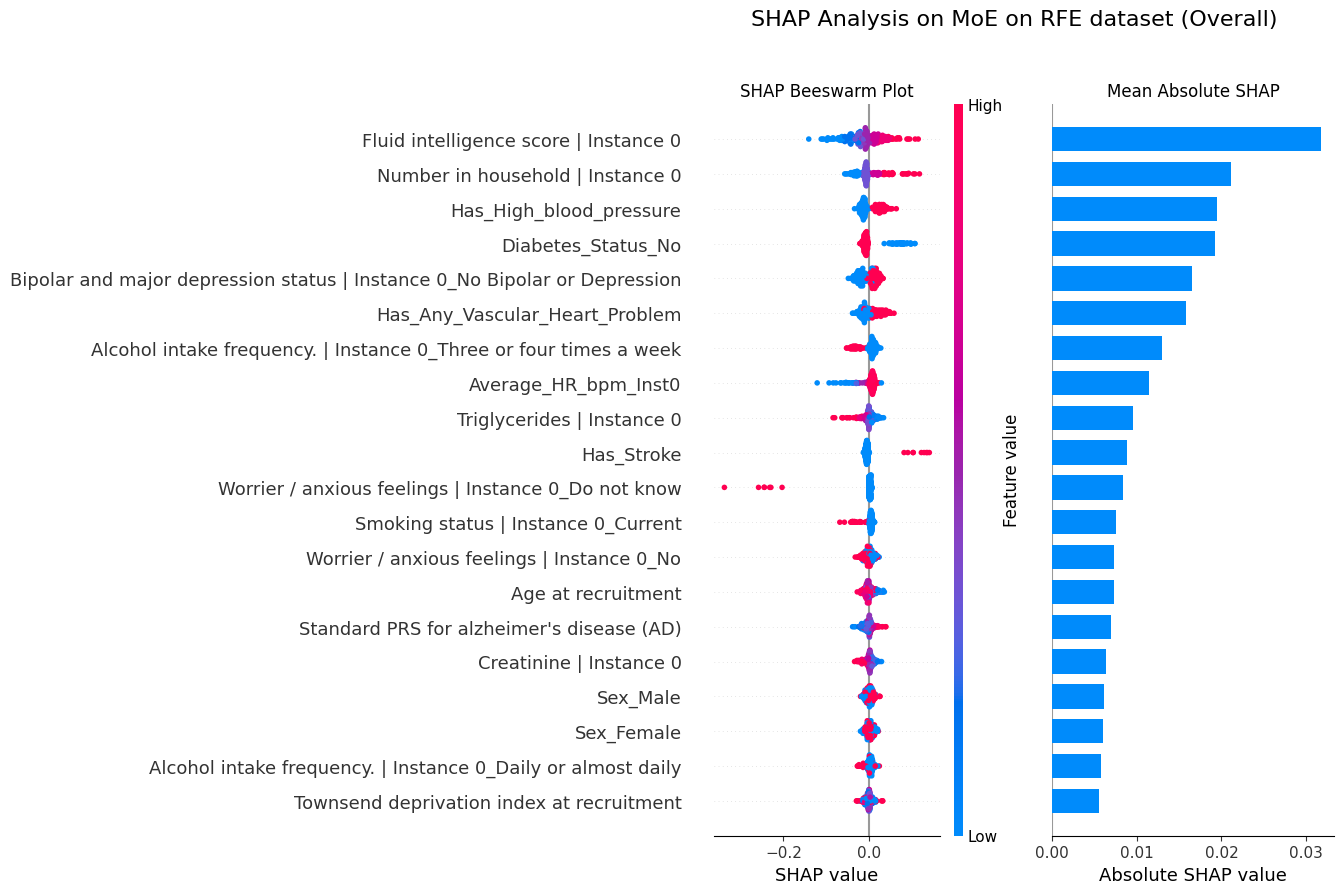



--- Analyzing Expert 1 ---


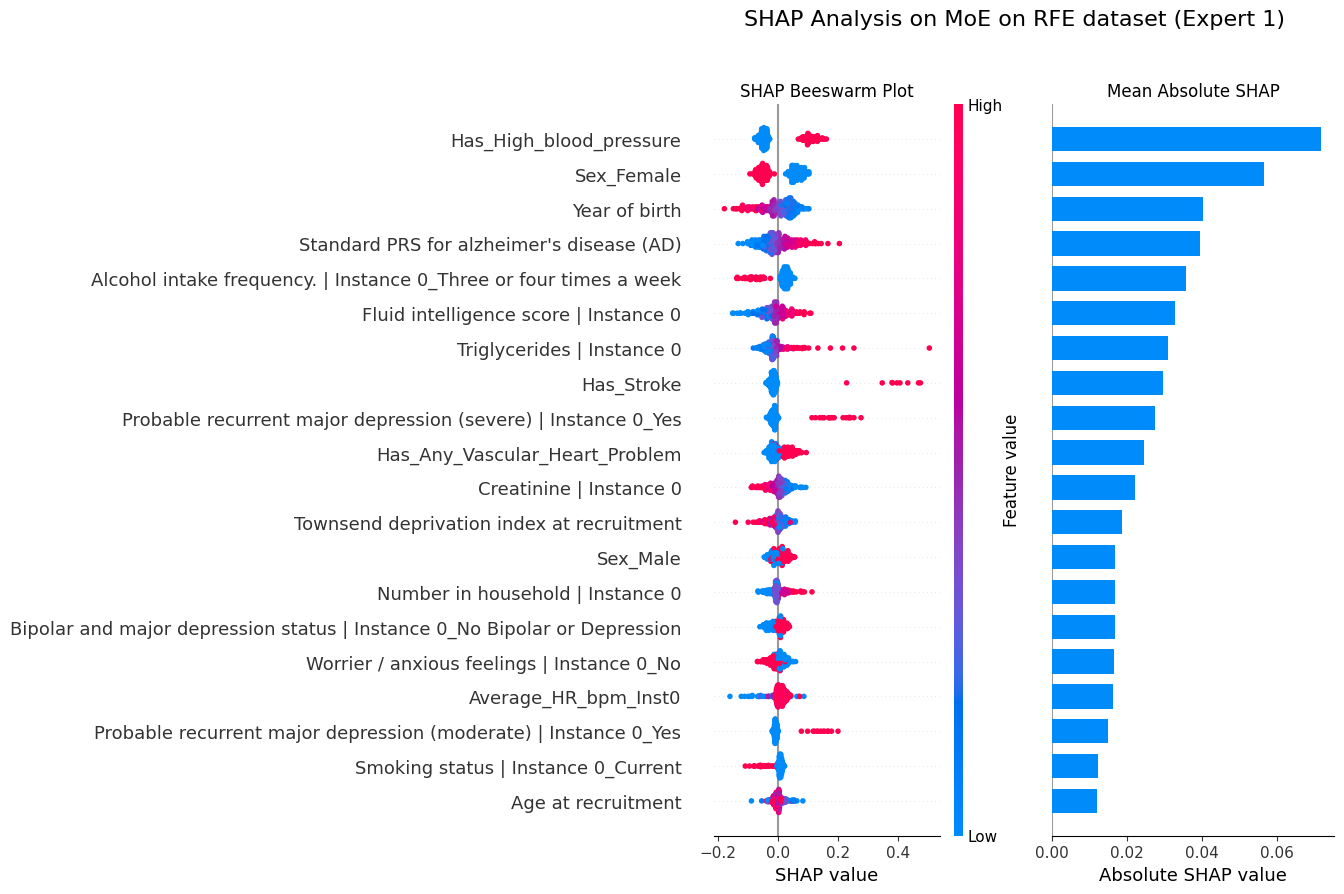



--- Analyzing Expert 2 ---


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


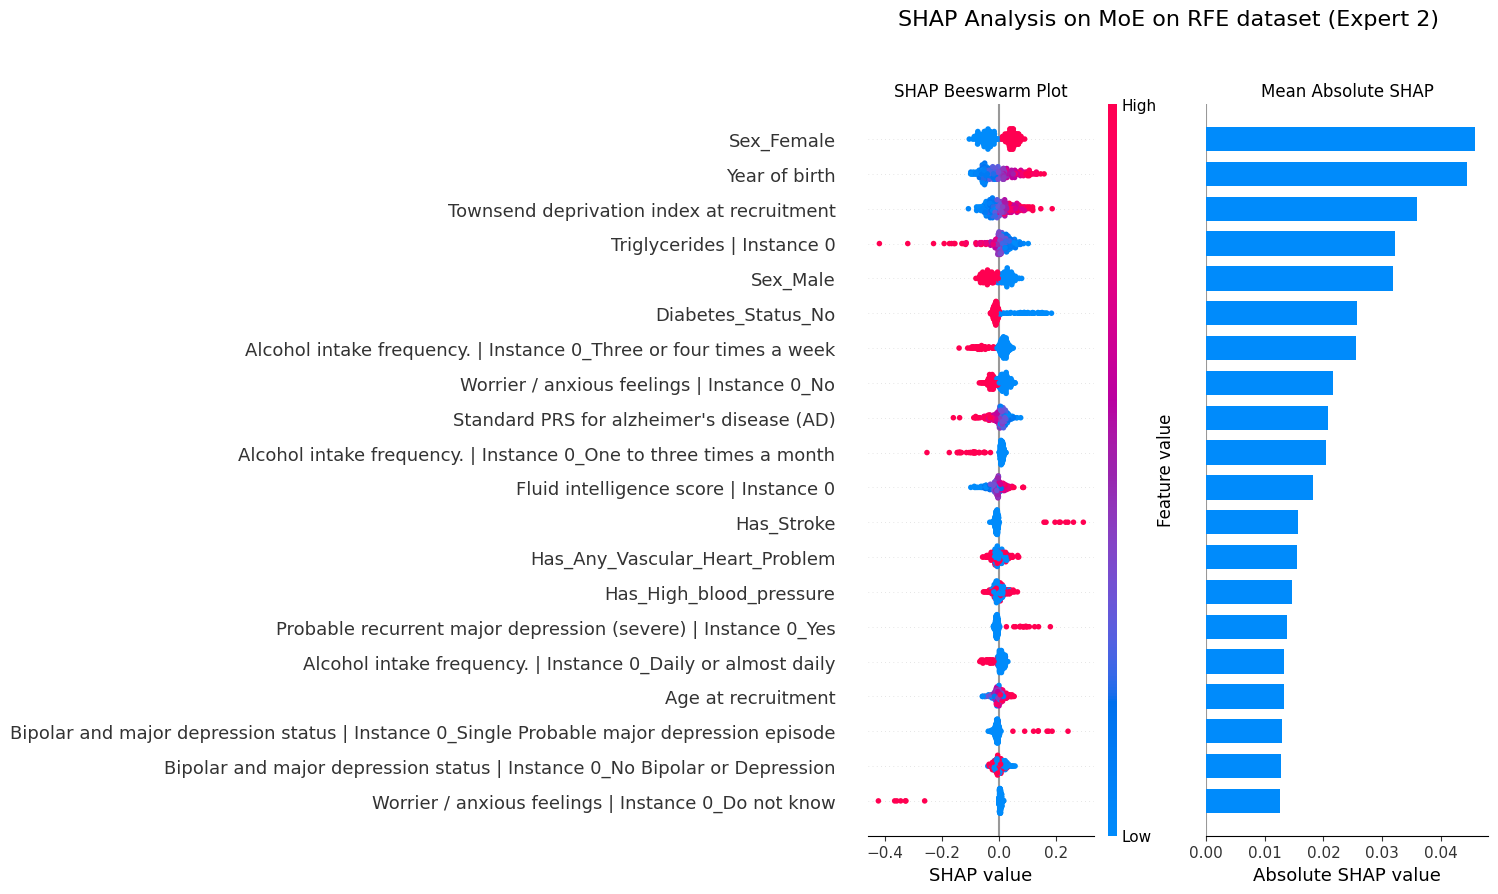



--- Analyzing Expert 3 ---


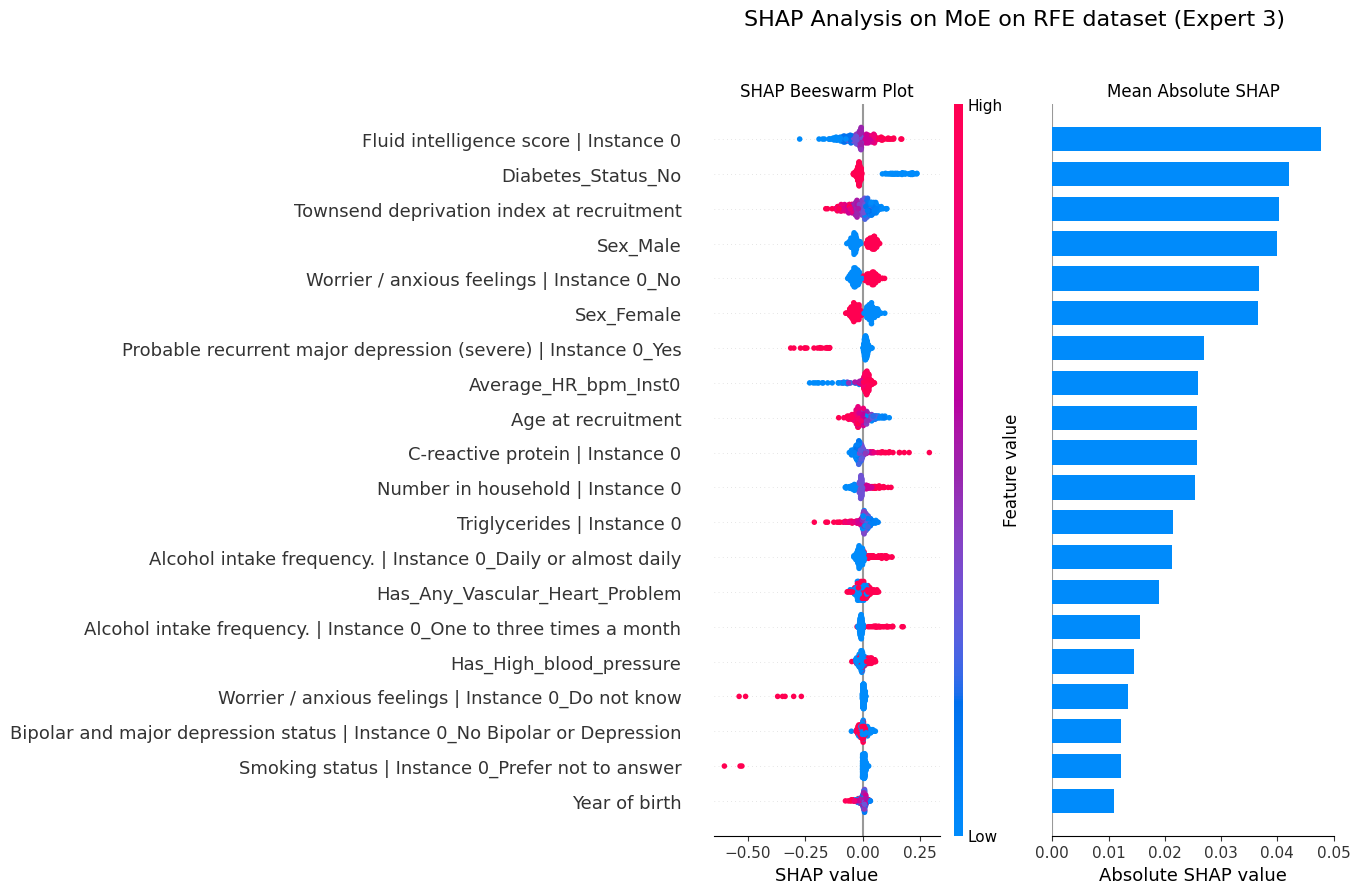



--- Analyzing Expert 4 ---


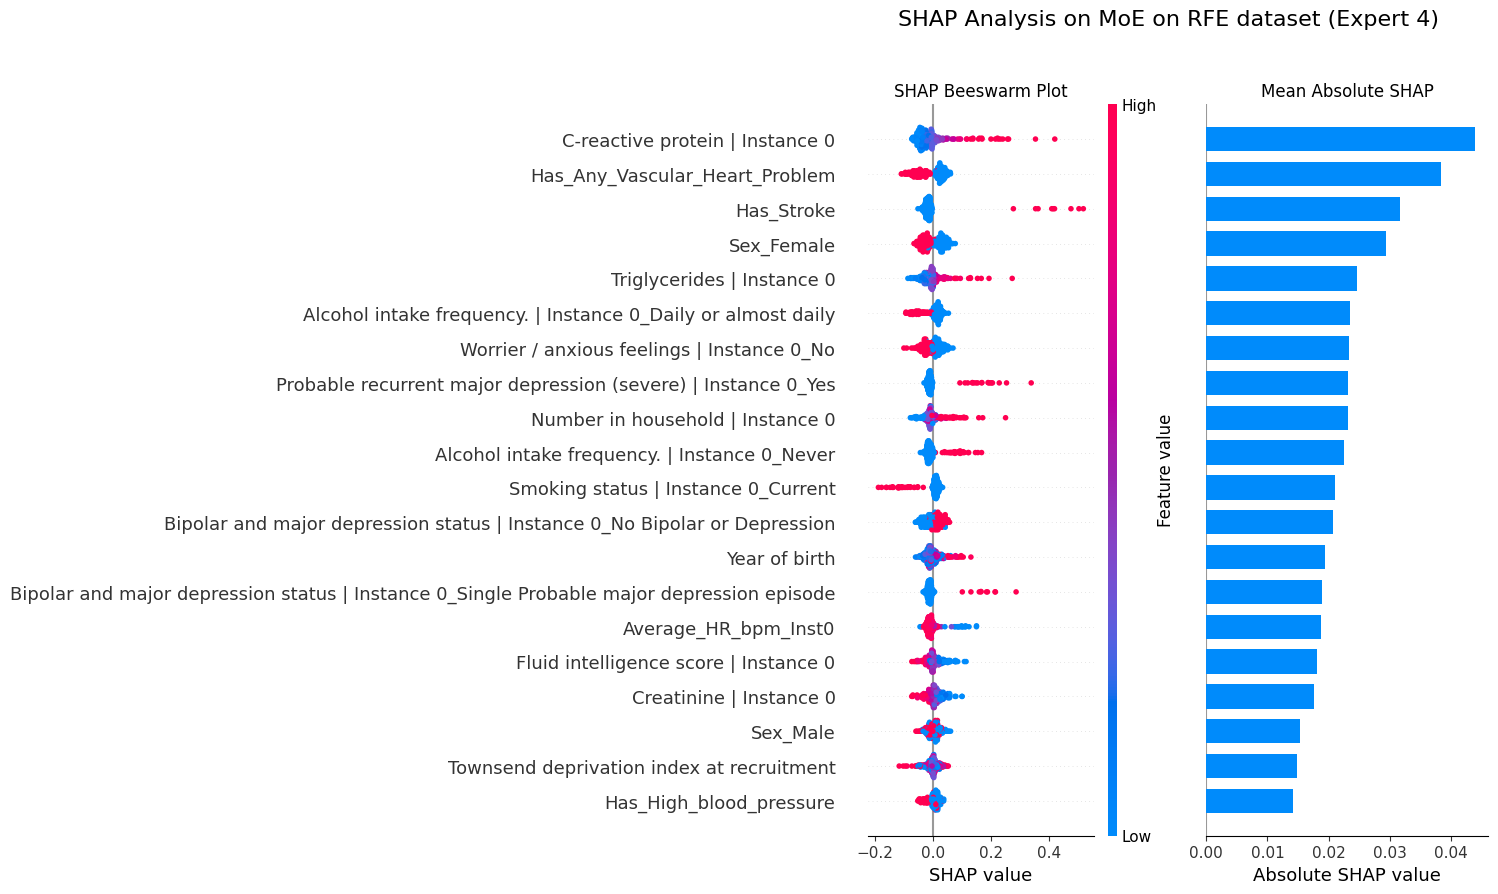



--- Analyzing Expert 5 ---


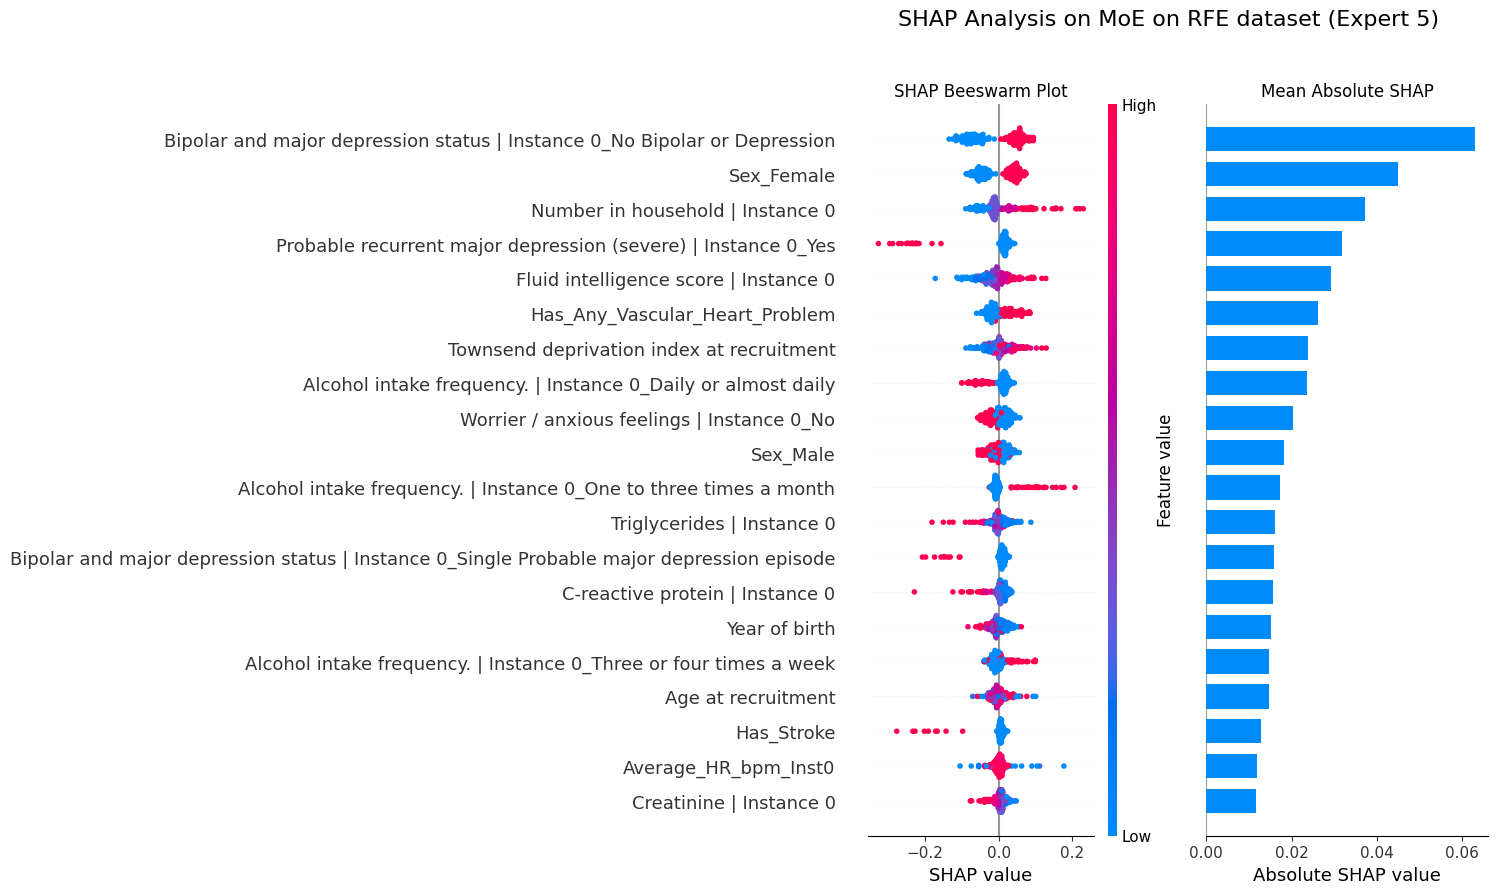



--- Analyzing Expert 6 ---


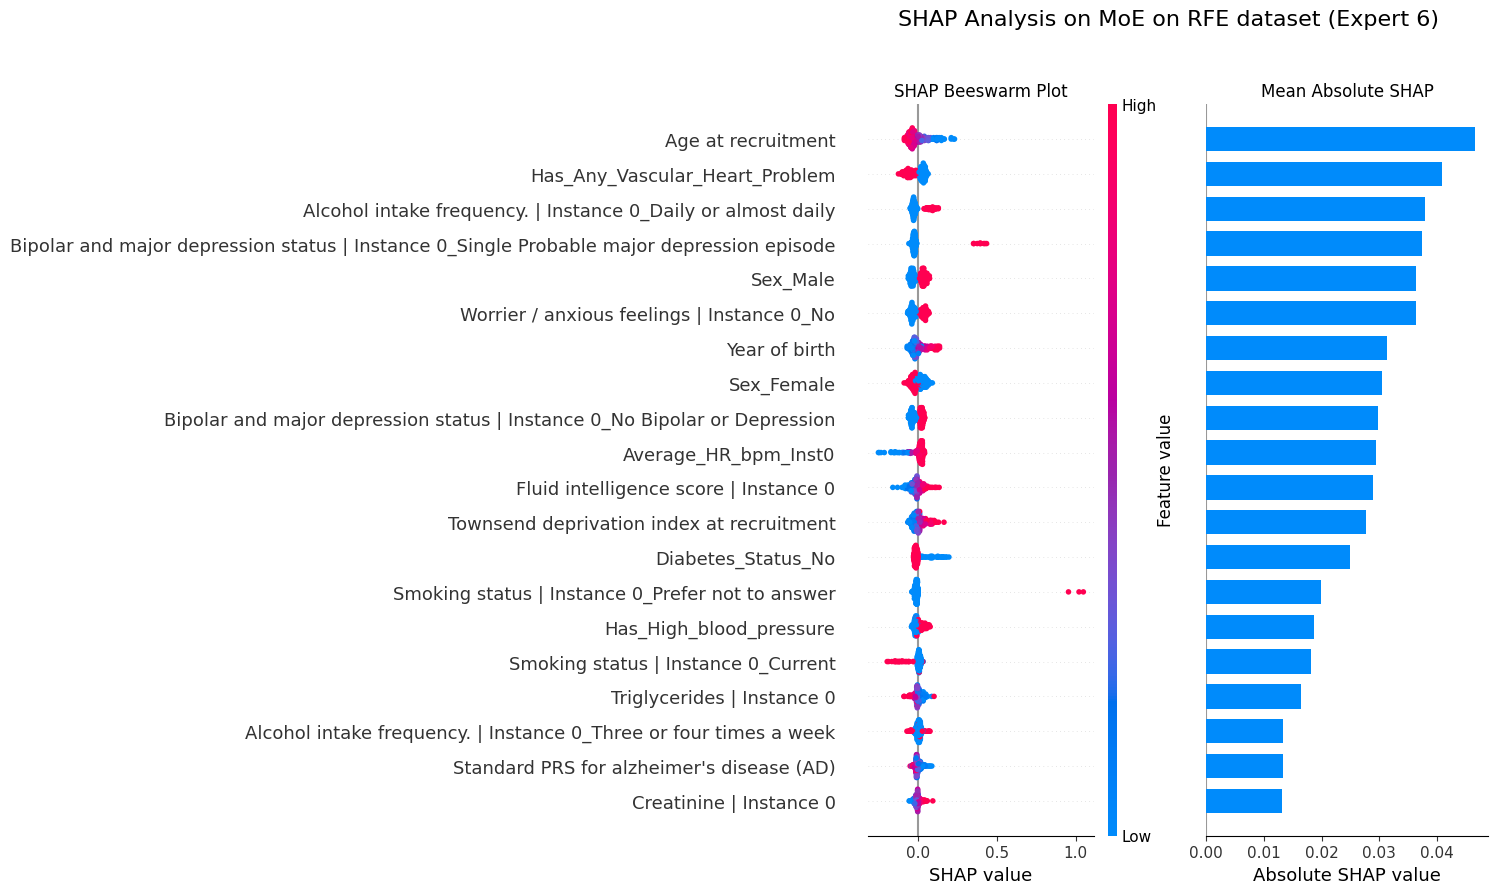

In [20]:
import shap
import matplotlib.pyplot as plt

# ===================================================================
# SHAP Analysis of the Final, Best Model and its Experts
# ===================================================================
print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis\n" + "="*40)

# --- 1. Prepare data for SHAP ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_model.to(device)
final_model.eval()

background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

# --- 2. SHAP Analysis for the OVERALL MoE Model ---
print("\n--- Analyzing Overall MoE Model ---")
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        self.model.train()
        pred, _ = self.model(x)
        return pred

shap_model_wrapper = ShapModelWrapper(final_model)
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)
shap_values = explainer.shap_values(test_tensor)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("SHAP Analysis on MoE on RFE dataset (Overall)", fontsize=16)
plt.sca(axes[0])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
axes[0].set_title("SHAP Beeswarm Plot")
axes[0].set_xlabel("SHAP value")
plt.sca(axes[1])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
axes[1].set_title("Mean Absolute SHAP")
axes[1].set_ylabel('')
axes[1].set_xlabel("Absolute SHAP value")
axes[1].set_yticklabels([])
#fig.tight_layout()
plt.show()

# --- 3. SHAP Analysis for INDIVIDUAL Experts ---
for i, expert_model in enumerate(final_model.experts):
    print(f"\n\n--- Analyzing Expert {i+1} ---")
    
    # Create a wrapper for the individual expert
    class ShapExpertWrapper(nn.Module):
        def __init__(self, model):
            super(ShapExpertWrapper, self).__init__()
            self.model = model
        def forward(self, x):
            return self.model(x)

    shap_expert_wrapper = ShapExpertWrapper(expert_model)
    expert_explainer = shap.GradientExplainer(shap_expert_wrapper, background_tensor)
    expert_shap_values = expert_explainer.shap_values(test_tensor)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(f"SHAP Analysis on MoE on RFE dataset (Expert {i+1})", fontsize=16)
    plt.sca(axes[0])
    shap.summary_plot(expert_shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
    axes[0].set_title(f"SHAP Beeswarm Plot")
    axes[0].set_xlabel("SHAP value")
    plt.sca(axes[1])
    shap.summary_plot(expert_shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
    axes[1].set_title(f"Mean Absolute SHAP")
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    axes[1].set_xlabel("Absolute SHAP value")
    #fig.tight_layout()
    plt.show()
